# Import Necessary Libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Import Ball by Ball Data of IPL

In [16]:
t20i = pd.read_csv(r"C:\Users\ariad\OneDrive\Desktop\Player_comparison\ipl_ball_by_ball.csv")
t20i

C:\Users\ariad\AppData\Local\Temp\ipykernel_18672\2221648505.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  t20i = pd.read_csv(r"C:\Users\ariad\OneDrive\Desktop\Player_comparison\ipl_ball_by_ball.csv")


,Match ID,season,Date,Venue,Innings,Ball,batting_team,bowling_team,Batter,Non Striker,...,other_player_dismissed,Bat First,Bat Second,Ball Rebowled,Over,Wicket,Batter Balls Faced,Total Batter Runs,Player Out Runs,Player Out Balls Faced
0,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,...,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,1.0,0,0,0.0
1,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,1.0,0,0,0.0
2,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,1.0,0,0,0.0
3,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,2.0,0,0,0.0
4,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,3.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2024,2024-05-26,"MA Chidambaram Stadium, Chepauk, Chennai",2,5,Kolkata Knight Riders,Sunrisers Hyderabad,SS Iyer,VR Iyer,...,NaN,Sunrisers Hyderabad,Kolkata Knight Riders,0,10,0,2.0,5,0,0.0
260916,1426312,2024,2024-05-26,"MA Chidambaram Stadium, Chepauk, Chennai",2,6,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,...,NaN,Sunrisers Hyderabad,Kolkata Knight Riders,0,10,0,24.0,50,0,0.0
260917,1426312,2024,2024-05-26,"MA Chidambaram Stadium, Chepauk, Chennai",2,1,Kolkata Knight Riders,Sunrisers Hyderabad,VR Iyer,SS Iyer,...,NaN,Sunrisers Hyderabad,Kolkata Knight Riders,0,11,0,25.0,51,0,0.0
260918,1426312,2024,2024-05-26,"MA Chidambaram Stadium, Chepauk, Chennai",2,2,Kolkata Knight Riders,Sunrisers Hyderabad,SS Iyer,VR Iyer,...,NaN,Sunrisers Hyderabad,Kolkata Knight Riders,0,11,0,3.0,6,0,0.0


# Player Stats Extraction

In [17]:
player_dataframes = {}
# Function to create CSV for each player
def createcsv(namee):
    # Find the full name of the player matching the input
    full_name = ''
    for name in t20i['Batter'].unique():
        if namee in name.lower():
            full_name = name
            break
    
    # Filter the dataframe for the specific player
    player_data = t20i[t20i['Batter'] == full_name]

    # Define the recommended columns
    recommended_columns = ['Match ID', 'Date', 'Venue', 'Bat First', 'Bat Second', 'Innings', 'Over', 'Ball', 'Batter', 'Bowler', 
                           'Batter Runs', 'Batter Balls Faced', 'Wicket', 'Method', 'Player Out', 'Player Out Runs', 'Player Out Balls Faced']
    
    # Select only the relevant columns
    player_data = player_data[recommended_columns]

    # Assign new match IDs for easier comparison
    match_id_mapping = {}
    match_id_counter = 1
    for match_id in player_data['Match ID'].unique():
        match_id_mapping[match_id] = f"Match {match_id_counter}"
        match_id_counter += 1

    player_data['Match ID'] = player_data['Match ID'].map(match_id_mapping)

    # Load the dataset for bowlers
    bowler_data = pd.read_csv(r"C:\Users\ariad\OneDrive\Desktop\Player_comparison\Bowler_data.csv")

    # Merge player data with bowler data to include bowling style
    data = player_data.merge(bowler_data, on='Bowler', how='left')

    # Define the phases of the game
    def assign_phase(over):
        if over <= 6:
            return 'Powerplay'
        elif 7 <= over <= 15:
            return 'Middle Overs'
        else:
            return 'Death Overs'

    # Assign phases to each ball
    data['Phase'] = data['Over'].apply(assign_phase)

    # Define classification for bowling styles
    classification = {
        'Pace': [
            'Right-arm medium', 'Right-arm fast-medium', 'Right-arm medium-fast', 'Left-arm fast-medium', 
            'Left-arm medium-fast', 'Right-arm fast', 'Left-arm medium', 'Left-arm fast', 'Right-arm bowler'
        ],
        'Spin': [
            'Right-arm offbreak', 'Legbreak googly', 'Slow left-arm orthodox', 'Slow left-arm chinaman', 'Legbreak'
        ]
    }

    # Function to classify bowlers
    def classify_bowler(style):
        if style in classification['Pace']:
            return 'Pace'
        elif style in classification['Spin']:
            return 'Spin'
        else:
            return 'Unknown'

    # Classify bowlers
    data['Bowling_Type'] = data['Bowling_Style'].apply(classify_bowler)

    # Group the data by 'Batter' and 'Phase' to calculate total runs, balls faced, and wickets
    player_stats = data.groupby(['Batter', 'Phase']).agg({
        'Batter Runs': 'sum',        # Total runs scored
        'Ball': 'count',             # Total balls faced
        'Method': lambda x: x.notnull().sum()  # Number of dismissals
    }).rename(columns={'Method': 'Dismissals'})

    # Calculate Batting Average (Runs / Dismissals)
    player_stats['Batting Average'] = player_stats['Batter Runs'] / player_stats['Dismissals'].replace(0, 1)

    # Calculate Strike Rate (Runs / Balls Faced * 100)
    player_stats['Strike Rate'] = (player_stats['Batter Runs'] / player_stats['Ball']) * 100

    # Count boundaries (4s and 6s)
    data['Fours'] = (data['Batter Runs'] == 4).astype(int)
    data['Sixes'] = (data['Batter Runs'] == 6).astype(int)

    # Sum up the boundaries for each player in each phase
    boundaries = data.groupby(['Batter', 'Phase'])[['Fours', 'Sixes']].sum()

    # Join the boundary data with the player stats
    player_stats = player_stats.join(boundaries)

    # Dismissal rate (Wickets / Balls Faced)
    player_stats['Dismissal Rate'] = player_stats['Dismissals'] / player_stats['Ball']

    # Initialize a list to store phase metrics
    phase_metrics = []

    # Define the phases
    phases = ['Powerplay', 'Middle Overs', 'Death Overs']

    for phase in phases:
        phase_data = data[data['Phase'] == phase]

        # Consistency metrics
        std_score = phase_data['Batter Runs'].std()
        dot_ball_percentage = (phase_data['Batter Runs'] == 0).sum() / len(phase_data) * 100

        # Boundary-hitting ability
        boundary_percentage = (phase_data['Batter Runs'].isin([4, 6]).sum() / len(phase_data)) * 100
        num_fours = (phase_data['Batter Runs'] == 4).sum()
        num_sixes = (phase_data['Batter Runs'] == 6).sum()
        ratio_4s_6s = num_fours / (num_sixes if num_sixes > 0 else 1)

        # Count dismissal types
        dismissal_counts = phase_data['Method'].value_counts().to_dict()

        # Count pace and spin dismissals
        pace_dismissals = phase_data[phase_data['Bowling_Type'] == 'Pace']['Method'].notnull().sum()
        spin_dismissals = phase_data[phase_data['Bowling_Type'] == 'Spin']['Method'].notnull().sum()
        
        # Calculate runs against pace and spin
        runs_against_pace = phase_data[phase_data['Bowling_Type'] == 'Pace']['Batter Runs'].sum()
        runs_against_spin = phase_data[phase_data['Bowling_Type'] == 'Spin']['Batter Runs'].sum()

        # Calculate runs and dismissals against others
        runs_against_other = phase_data[phase_data['Bowling_Type'] == 'Unknown']['Batter Runs'].sum()
        runs_against_pace += runs_against_other / 2
        runs_against_spin += runs_against_other / 2
        other_dismissals = phase_data[phase_data['Bowling_Type'] == 'Unknown']['Method'].notnull().sum()
        pace_dismissals += other_dismissals / 2
        spin_dismissals += other_dismissals / 2

        # Append the calculated metrics for the current phase to phase_metrics
        metrics = {
            'Phase': phase,
            'Score Std Dev': std_score,
            'Dot Ball %': dot_ball_percentage,
            'Boundary %': boundary_percentage,
            '4s to 6s Ratio': ratio_4s_6s,
            'Total Fours': num_fours,
            'Total Sixes': num_sixes,
            'Pace Dismissals': pace_dismissals,
            'Spin Dismissals': spin_dismissals,
            'Runs Against Pace': runs_against_pace,
            'Runs Against Spin': runs_against_spin
        }

        # Add dismissal counts to the metrics dictionary
        for dismissal_type, count in dismissal_counts.items():
            metrics[dismissal_type] = count

        phase_metrics.append(metrics)

    # Convert the list of phase metrics into a DataFrame
    phase_metrics_df = pd.DataFrame(phase_metrics)

    # Merge the phase metrics with player stats
    final_stats = player_stats.reset_index().merge(phase_metrics_df, on='Phase', how='left')

    # List of dismissal types that are expected
    dismissal_types = ['caught', 'bowled', 'lbw', 'run out', 'caught and bowled', 'stumped']

    # Add missing dismissal columns with default value of 0
    for dismissal_type in dismissal_types:
        if dismissal_type not in final_stats.columns:
            final_stats[dismissal_type] = 0

    # Define the desired order of the columns
    columns_order = [
        'Batter', 'Phase', 'Batter Runs', 'Runs Against Pace', 'Runs Against Spin', 'Ball', 
        'Batting Average', 'Strike Rate', 'Fours', 
        'Sixes', 'Boundary %', '4s to 6s Ratio', 
        'Score Std Dev', 'Dismissals', 'Pace Dismissals', 'Spin Dismissals', 
        'caught', 'bowled', 'lbw', 'run out', 'caught and bowled', 
        'stumped', 'Dismissal Rate'
    ]

    # Rearranging the columns in the desired order
    try:
        final_stats_sorted = final_stats[columns_order]
    except KeyError as e:
        print(f"KeyError: {e} - One or more columns could not be found.")
        # Handle missing columns if necessary, e.g., create a version without missing columns
        final_stats_sorted = final_stats[final_stats.columns.intersection(columns_order)]

    # Sort by 'Phase' to ensure the phases are ordered
    final_stats_sorted = final_stats_sorted.sort_values(by='Phase', key=lambda x: x.map({
        'Powerplay': 0, 'Middle Overs': 1, 'Death Overs': 2
    }))

    # Reset index for a cleaner look
    final_stats_sorted.reset_index(drop=True, inplace=True)
    player_dataframes[full_name] = final_stats_sorted

list_of_players=['kohli','williamson','warner','dhawan','raina','sharma','villiers','gayle','samson','plessis', 's iyer', 'buttler', 'agarwal', 
                 'kishan', 'tripathi', 'padikkal', 'gurbaz', 'markram', 'kl rahul', 'gill', 'gambhir', 'mccullum', 'rayudu', 'n rana', 
                 'rahane', 'kock', 'uthappa', 'watson', 'saha', 'm vijay', 'sehwag']

# Loop through all players and create CSV files
for nameee in list_of_players:
    createcsv(nameee)


In [18]:
player_dataframes['V Kohli']

,Batter,Phase,Batter Runs,Runs Against Pace,Runs Against Spin,Ball,Batting Average,Strike Rate,Fours,Sixes,...,Dismissals,Pace Dismissals,Spin Dismissals,caught,bowled,lbw,run out,caught and bowled,stumped,Dismissal Rate
0,V Kohli,Powerplay,2809,2035.5,773.5,2347,40.128571,119.684704,348,68,...,70,51.5,18.5,44,12,8,5,1,NaN,0.029825
1,V Kohli,Middle Overs,3736,1709.0,2027.0,3065,42.942529,121.892333,252,117,...,87,52.0,35.0,53,18,2,9,2,3.0,0.028385
2,V Kohli,Death Overs,1469,1028.0,441.0,824,24.081967,178.276699,108,88,...,61,48.5,12.5,41,9,2,6,1,2.0,0.074029


# Similarity Assessment

### K-Nearest Neighbors (KNN)
- The code utilizes the **K-Nearest Neighbors (KNN)** algorithm for identifying similar players based on their performance metrics.
- KNN computes distances based on both **Euclidean distance** and **Cosine similarity**.
- The nearest neighbors are determined using the metrics for the target player (i.e., Virat Kohli), and the most similar player is identified.

### 1. Euclidean Distance
- Definition: Measures the straight-line distance between two points in a multi-dimensional space, with each player's statistics as a point.
- How It Works: Calculates the absolute values of metrics, reflecting overall performance. Players with similar statistics score closely, regardless of specific performance traits.

### 2. Cosine Similarity
- Definition: Measures the cosine of the angle between two vectors, focusing on the orientation of performance metrics rather than magnitude.
- How It Works: Treats metrics as vectors, assessing similarity in scoring patterns rather than total runs.

### Implications of Differences
- A player may have similar overall statistics to Kohli (Euclidean) but differ in playing style (Cosine), leading to variations in similarity rankings.

    - Euclidean for overall performance similarity.
    - Cosine for style and scoring pattern similarity.


In [19]:
# Combine dataframes across all players and phases into a single dataframe for easier processing
combined_df = pd.concat(player_dataframes.values(), ignore_index=True)

# Standardize the numeric columns (scaling all columns to have mean 0 and std 1)
numeric_columns = [
    'Batter Runs', 'Runs Against Pace', 'Runs Against Spin', 'Ball', 
    'Batting Average', 'Strike Rate', 'Fours', 'Sixes', 'Boundary %', 
    '4s to 6s Ratio', 'Score Std Dev', 'Dismissals', 'Pace Dismissals', 
    'Spin Dismissals', 'caught', 'bowled', 'lbw', 'run out', 
    'caught and bowled', 'stumped', 'Dismissal Rate'
]

# Impute missing values with 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
combined_df[numeric_columns] = imputer.fit_transform(combined_df[numeric_columns])

# Normalize the numeric columns
scaler = StandardScaler()
combined_df[numeric_columns] = scaler.fit_transform(combined_df[numeric_columns])

# Function to get distances using Euclidean Distance and find the most similar player
def get_all_distances_and_most_similar_euclidean(df, target_player='V Kohli', phase='Powerplay'):
    phase_df = df[df['Phase'] == phase]
    kohli_data = phase_df[phase_df['Batter'] == target_player][numeric_columns].values
    other_players = phase_df[phase_df['Batter'] != target_player]
    
    knn = NearestNeighbors(n_neighbors=len(other_players), metric='euclidean')
    knn.fit(other_players[numeric_columns])
    
    distances, indices = knn.kneighbors(kohli_data)
    
    # Create a DataFrame of players and their distances
    distances_df = pd.DataFrame({
        'Player': other_players['Batter'].values,
        'Distance (Euclidean)': distances.flatten()
    })
    
    # Get the most similar player
    most_similar_player = distances_df.loc[distances_df['Distance (Euclidean)'].idxmin()]
    
    return distances_df.sort_values(by='Distance (Euclidean)'), most_similar_player

# Function to get distances using Cosine Similarity and find the most similar player
def get_all_distances_and_most_similar_cosine(df, target_player='V Kohli', phase='Powerplay'):
    phase_df = df[df['Phase'] == phase]
    kohli_data = phase_df[phase_df['Batter'] == target_player][numeric_columns].values
    other_players = phase_df[phase_df['Batter'] != target_player]
    
    # Calculate cosine similarities
    similarities = cosine_similarity(kohli_data, other_players[numeric_columns])
    distances = 1 - similarities.flatten()  # Convert similarity to distance
    
    # Create a DataFrame of players and their distances
    distances_df = pd.DataFrame({
        'Player': other_players['Batter'].values,
        'Distance (Cosine)': distances
    })
    
    # Get the most similar player
    most_similar_player = distances_df.loc[distances_df['Distance (Cosine)'].idxmin()]
    
    return distances_df.sort_values(by='Distance (Cosine)'), most_similar_player

# Initialize a dictionary to hold overall distances for the most similar players
overall_distances_euclidean = {}
overall_distances_cosine = {}
euclidean_distances_all = {}
cosine_distances_all = {}

# List to hold results for concatenation
results_list = []

# Compare results for each phase
for phase in ['Powerplay', 'Middle Overs', 'Death Overs']:
    euclidean_distances, most_similar_euclidean = get_all_distances_and_most_similar_euclidean(combined_df, phase=phase)
    cosine_distances, most_similar_cosine = get_all_distances_and_most_similar_cosine(combined_df, phase=phase)
    euclidean_distances_all[phase] = euclidean_distances
    cosine_distances_all[phase] = cosine_distances
    #print(f'--- {phase} ---')
    #print(f'Most Similar Player (Euclidean): {most_similar_euclidean["Player"]} (Distance: {most_similar_euclidean["Distance (Euclidean)"]})')
    #print(f'Most Similar Player (Cosine): {most_similar_cosine["Player"]} (Distance: {most_similar_cosine["Distance (Cosine)"]})')
    
    # Store results in list
    results_list.append({
        'Phase': phase,
        'Metric': 'Euclidean',
        'Most Similar Player': most_similar_euclidean['Player'],
        'Distance': most_similar_euclidean['Distance (Euclidean)']
    })

    results_list.append({
        'Phase': phase,
        'Metric': 'Cosine',
        'Most Similar Player': most_similar_cosine['Player'],
        'Distance': most_similar_cosine['Distance (Cosine)']
    })

    # Store distances for plotting
    overall_distances_euclidean[most_similar_euclidean['Player']] = most_similar_euclidean['Distance (Euclidean)']
    overall_distances_cosine[most_similar_cosine['Player']] = most_similar_cosine['Distance (Cosine)']
    
# Create DataFrame from results list
results_df = pd.DataFrame(results_list)

# Get the overall most similar player by finding the one with the least total distance
overall_most_similar_euclidean = min(overall_distances_euclidean, key=overall_distances_euclidean.get)
overall_most_similar_cosine = min(overall_distances_cosine, key=overall_distances_cosine.get)

# Create DataFrames for overall results
overall_results = pd.DataFrame([
    {
        'Phase': 'Overall',
        'Metric': 'Euclidean',
        'Most Similar Player': overall_most_similar_euclidean,
        'Distance': overall_distances_euclidean[overall_most_similar_euclidean]
    },
    {
        'Phase': 'Overall',
        'Metric': 'Cosine',
        'Most Similar Player': overall_most_similar_cosine,
        'Distance': overall_distances_cosine[overall_most_similar_cosine]
    }
])

# Concatenate overall results with the existing results_df
results_df = pd.concat([results_df, overall_results], ignore_index=True)
results_df
#print(f'\nOverall Most Similar Player (Euclidean): {overall_most_similar_euclidean} (Distance: {overall_distances_euclidean[overall_most_similar_euclidean]})')
#print(f'Overall Most Similar Player (Cosine): {overall_most_similar_cosine} (Distance: {overall_distances_cosine[overall_most_similar_cosine]})')

,Phase,Metric,Most Similar Player,Distance
0,Powerplay,Euclidean,KS Williamson,2.720447
1,Powerplay,Cosine,DA Warner,0.103638
2,Middle Overs,Euclidean,KS Williamson,3.631053
3,Middle Overs,Cosine,DA Warner,0.094542
4,Death Overs,Euclidean,KS Williamson,1.991914
5,Death Overs,Cosine,RG Sharma,0.108374
6,Overall,Euclidean,KS Williamson,1.991914
7,Overall,Cosine,DA Warner,0.094542


# Visualization of results

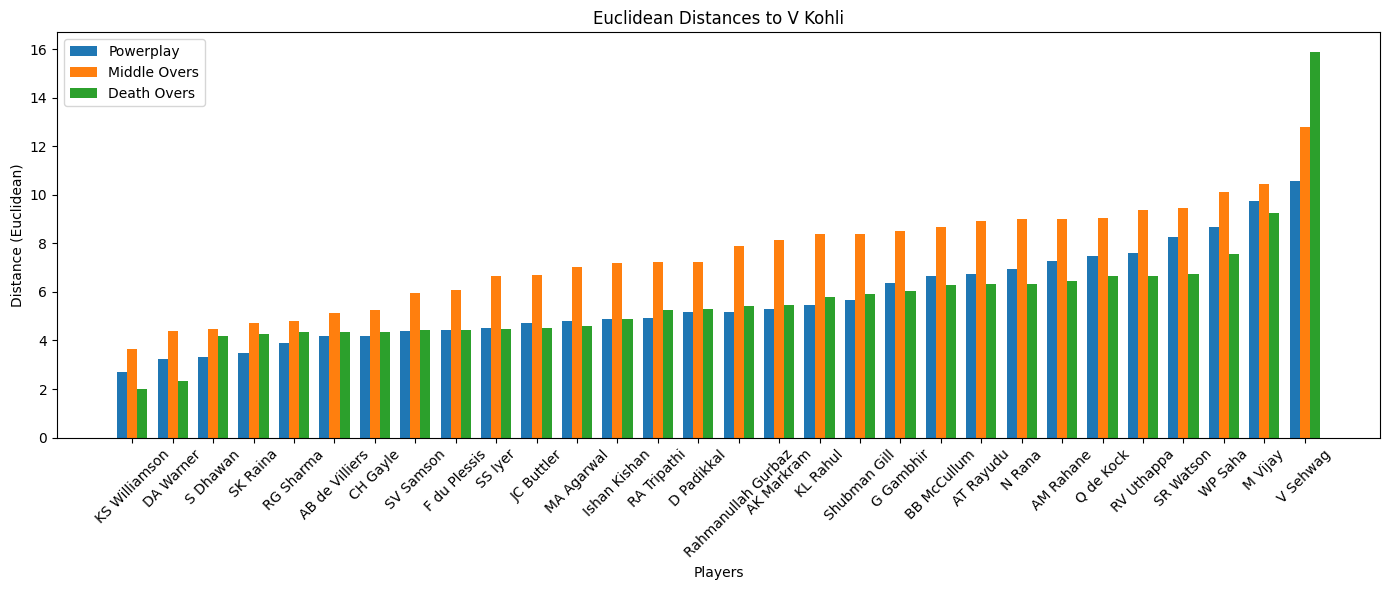

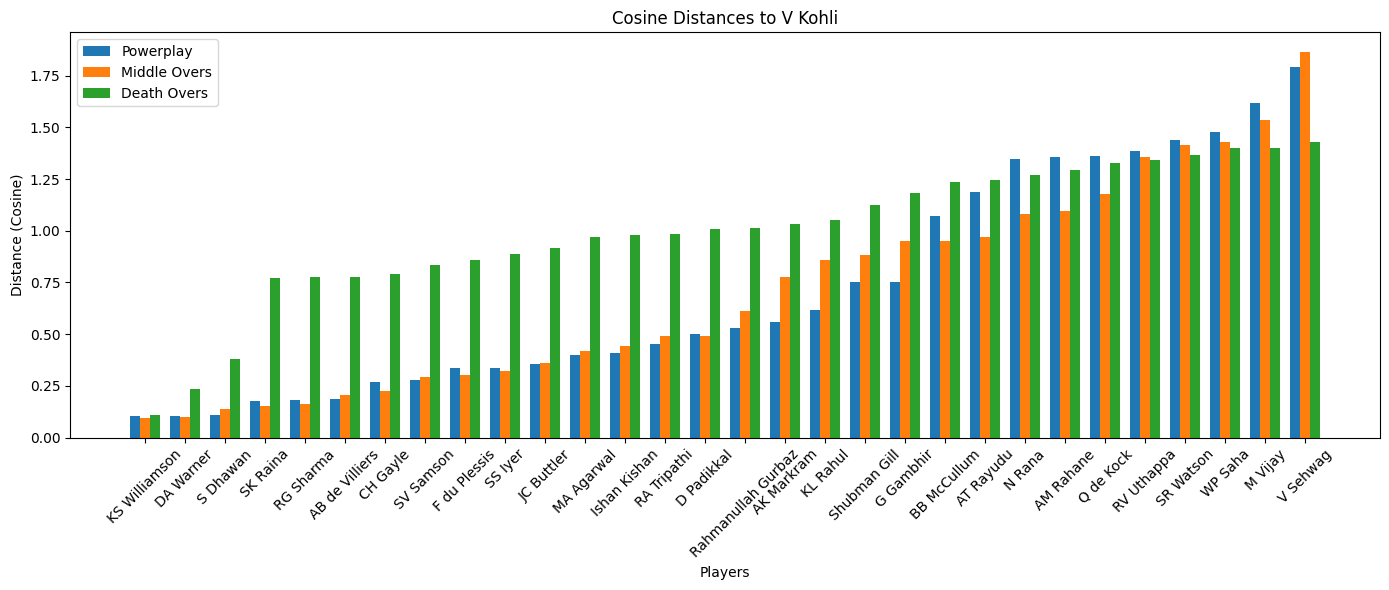

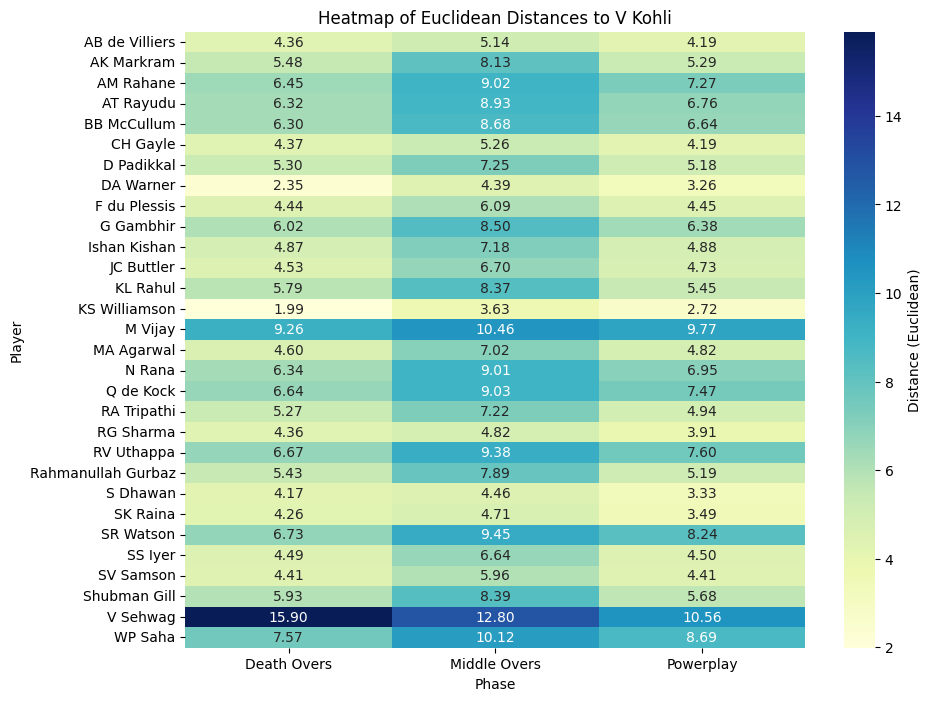

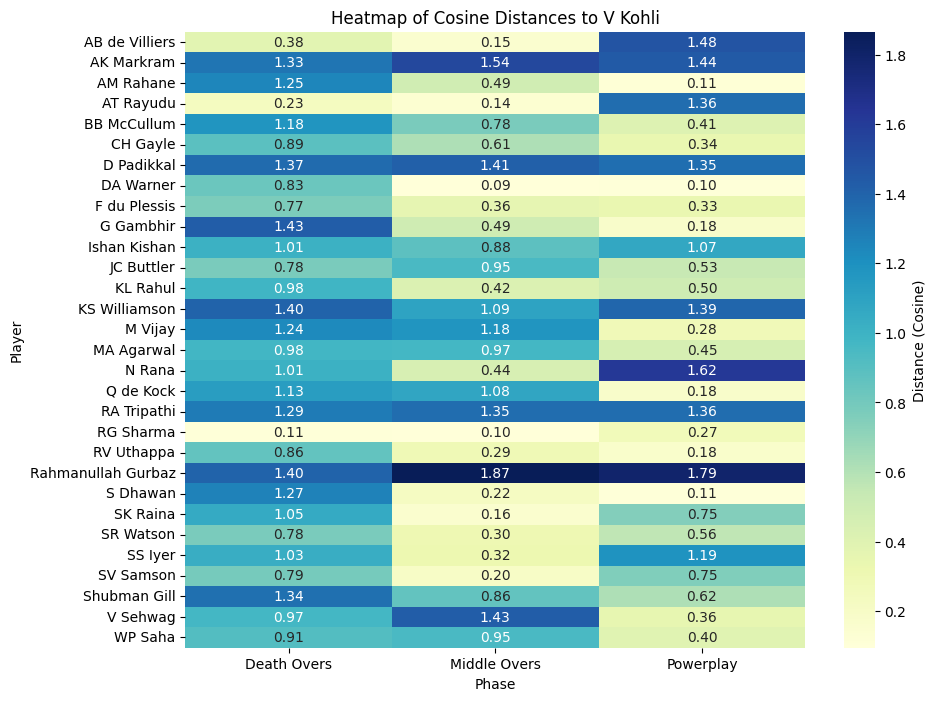

In [20]:
# Visualization of results - Bar Plot for Euclidean Distances
plt.figure(figsize=(14, 6))
bar_width = 0.25  # Width of the bars
x_labels = list(euclidean_distances_all['Powerplay']['Player'])  # Unique player names
x_positions = range(len(x_labels))

# Loop through phases to plot each one separately
for i, phase in enumerate(euclidean_distances_all):
    plt.bar([x + i * bar_width for x in x_positions], 
            euclidean_distances_all[phase]['Distance (Euclidean)'], 
            width=bar_width, 
            label=phase)

plt.title('Euclidean Distances to V Kohli')
plt.xlabel('Players')
plt.ylabel('Distance (Euclidean)')
plt.xticks([x + bar_width for x in x_positions], x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Visualization of results - Bar Plot for Cosine Distances
plt.figure(figsize=(14, 6))
x_positions = range(len(x_labels))  # Unique player names

# Loop through phases to plot each one separately
for i, phase in enumerate(cosine_distances_all):
    plt.bar([x + i * bar_width for x in x_positions], 
            cosine_distances_all[phase]['Distance (Cosine)'], 
            width=bar_width, 
            label=phase)

plt.title('Cosine Distances to V Kohli')
plt.xlabel('Players')
plt.ylabel('Distance (Cosine)')
plt.xticks([x + bar_width for x in x_positions], x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap for Euclidean Distances
all_euclidean_data = pd.concat([euclidean_distances_all[phase].assign(Phase=phase) for phase in euclidean_distances_all])
euclidean_heatmap_data = pd.pivot_table(
    all_euclidean_data,
    values='Distance (Euclidean)',
    index='Player',
    columns='Phase'
)

plt.figure(figsize=(10, 8))
sns.heatmap(euclidean_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Distance (Euclidean)'})
plt.title('Heatmap of Euclidean Distances to V Kohli')
plt.show()

# Heatmap for Cosine Distances
all_cosine_data = pd.concat([cosine_distances_all[phase].assign(Phase=phase) for phase in cosine_distances_all])
cosine_heatmap_data = pd.pivot_table(
    all_cosine_data,
    values='Distance (Cosine)',
    index='Player',
    columns='Phase'
)

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Distance (Cosine)'})
plt.title('Heatmap of Cosine Distances to V Kohli')
plt.show()